<a href="https://colab.research.google.com/github/Maryam-Afshari/thesis/blob/master/MLR_Basel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# checking out the GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul  5 14:20:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# checking out the memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#Running MLR on Basel station 

In [5]:
#!pip install hydroeval

In [6]:
# required libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import hydroeval as he
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# reading data
basel= pd.read_csv('/content/drive/MyDrive/Thesis-Afshari/data/basel.csv',index_col=0)
q_basel = pd.read_csv("/content/drive/MyDrive/Thesis-Afshari/data/q_basel.csv",index_col=0)


### Feature engineering

In [24]:
# making lagged variables

# define the number of lags
TIME_STEPS = 60

#add the lagged variables for predictors to the dataframe
for i, var in enumerate(basel[["et","p","t"]]):
  for step in range(0, TIME_STEPS - 1):
    basel.insert(i*(TIME_STEPS) + 1,
                 f'{var}_lag_{TIME_STEPS - 1 - step}',
                 basel[var].shift(TIME_STEPS - 1 - step))

#remove the first TIME_STEPS - 1 rows since they will contain NA values
basel = basel.iloc[TIME_STEPS - 1:,:].reset_index(drop=True)
q_basel = q_basel.iloc[TIME_STEPS - 1:,:].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if self.run_code(code, result):


### Train-test split and defineing variables


In [25]:
# train-test split
len_ = int(0.75 * basel.shape[0])

df_train = basel[:len_]
df_test = basel[len_:]

# x-train without lagged vars
X_train = df_train[["et","t","p"]]

# x-train with lagged vars
X_train_lagged = df_train.drop(columns = ["obs","datetime"], axis =1)
y_train = df_train.obs

# x-test without lagged vars
X_test = df_test[["et","t","p"]]

# x-test with lagged vars
X_test_lagged = df_test.drop(columns = ["obs","datetime"], axis =1)
y_test = df_test.obs

In [26]:
# getting the names of features 
feature_names = X_train.columns

# getting the names of features of the  MLR_lag 
feature_names_lagged = X_train_lagged.columns

In [ ]:
# saving obs of y_test
#np.save("/content/drive/MyDrive/Thesis-Afshari/output/obs_MLR_60lag.npy", y_test, allow_pickle=True)

### Normalising data

In [27]:
# normalising perdictors 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# normalising perdictors for model with the lagged varibales
scaler_lagged = MinMaxScaler()
X_train_lagged = scaler_lagged.fit_transform(X_train_lagged)
X_test_lagged = scaler_lagged.transform(X_test_lagged)

### Model

In [28]:
# creating an object of LinearRegression class
lm = LinearRegression()

# fitting the training data
lm.fit(X_train, y_train)

# evaluating the model
lm.score(X_test, y_test)

0.12075166081013522

In [29]:
# getting the intercept of the MLR_S model 
lm.intercept_

907.3718629891398

In [30]:
# getting the coefficients of the model 
model_coefficients = lm.coef_


# reading the coefficients in a data frame
coefficients_df = pd.DataFrame(data = model_coefficients, 
                              index = feature_names, 
                              columns = ['Coefficient value'])
print(coefficients_df)

    Coefficient value
et         921.082341
t         -192.024727
p          876.144206


In [31]:
# creating an object of LinearRegression class
lm_lag = LinearRegression()

# fitting the training data for model with the lagged variables
lm_lag.fit(X_train_lagged,y_train)

# evaluating the model
lm_lag.score(X_test_lagged, y_test)

0.6796257969848057

In [32]:
# getting the intercept of the MLR_lag model
lm_lag.intercept_

-273.62687550122655

In [34]:
# getting the coefficients of the MLR_lag model 
model_coefficients_lagged = lm_lag.coef_

# reading the coefficients in a data frame
coefficients_lagged_df = pd.DataFrame(data = model_coefficients_lagged, 
                              index = feature_names_lagged, 
                              columns = ['Coefficient_value'])


# plot the coefficients

In [35]:
# getting the coefficients to plot 
df_et_coe = coefficients_lagged_df[coefficients_lagged_df.index.str.startswith("et")]
df_t_coe = coefficients_lagged_df[coefficients_lagged_df.index.str.startswith("t")]
df_p_coe = coefficients_lagged_df[coefficients_lagged_df.index.str.startswith("p")]
df_negative_coe = coefficients_lagged_df[coefficients_lagged_df.Coefficient_value < 0]


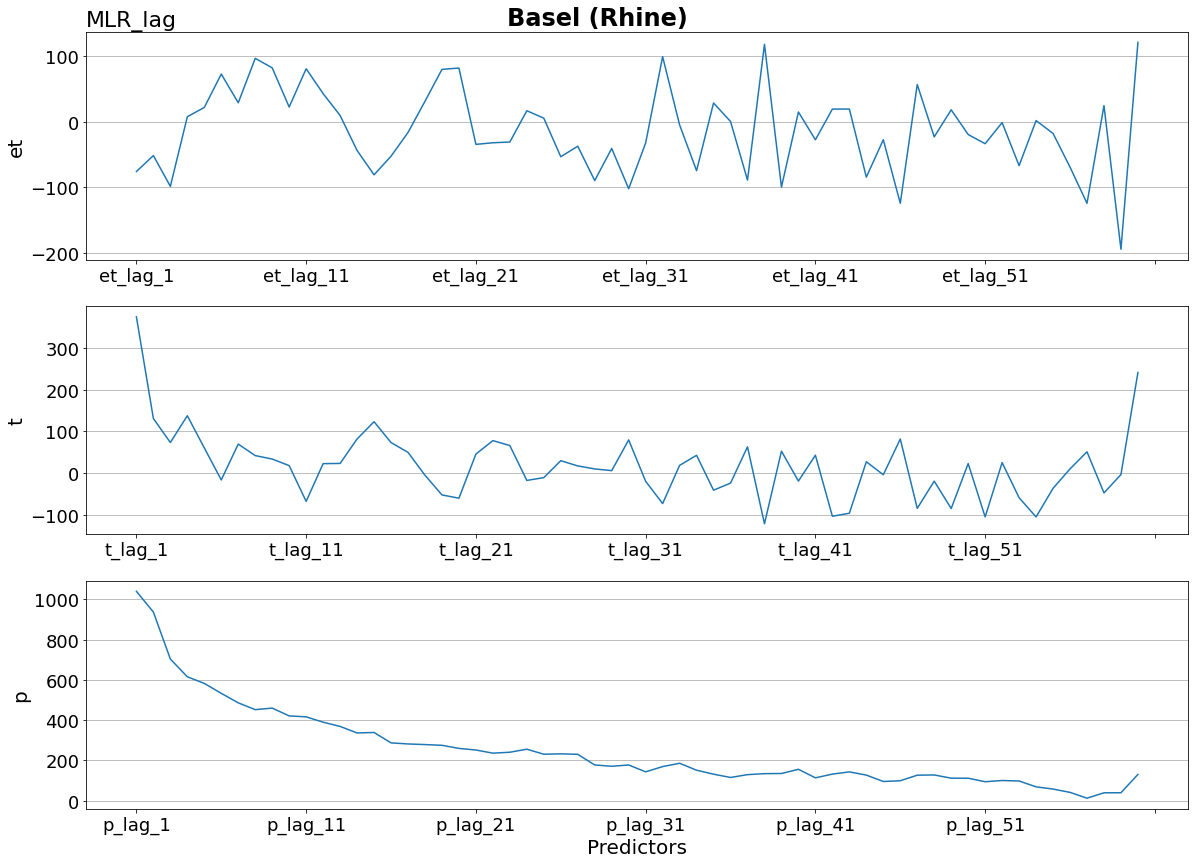

In [38]:
# pltoing the coefficients of the MLR_lag

plt.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(17, 20*2/(1+5**0.5)))  
df_et_coe.plot(ax = axes[0], legend=False, ylabel = "et", label = "Coefficient") 
df_t_coe.plot(ax = axes[1],  legend=False, ylabel = "t")
df_p_coe.plot(ax = axes[2],  legend=False, ylabel = "p", xlabel = "Predictors") 


# tweak the axes
axes[0].set_title("MLR_lag", loc ="left", fontsize =22)


for ax in axes:
  ax.grid(axis = 'y')
  ax.tick_params(axis='y', labelsize=18)
  ax.tick_params(axis='x', labelsize=18)

fig.suptitle('Basel (Rhine)',fontweight ="bold")
fig.tight_layout()
# saving the fig
plt.savefig("/content/drive/MyDrive/Thesis-Afshari/figures/coeficient_basel.png")
plt.show()


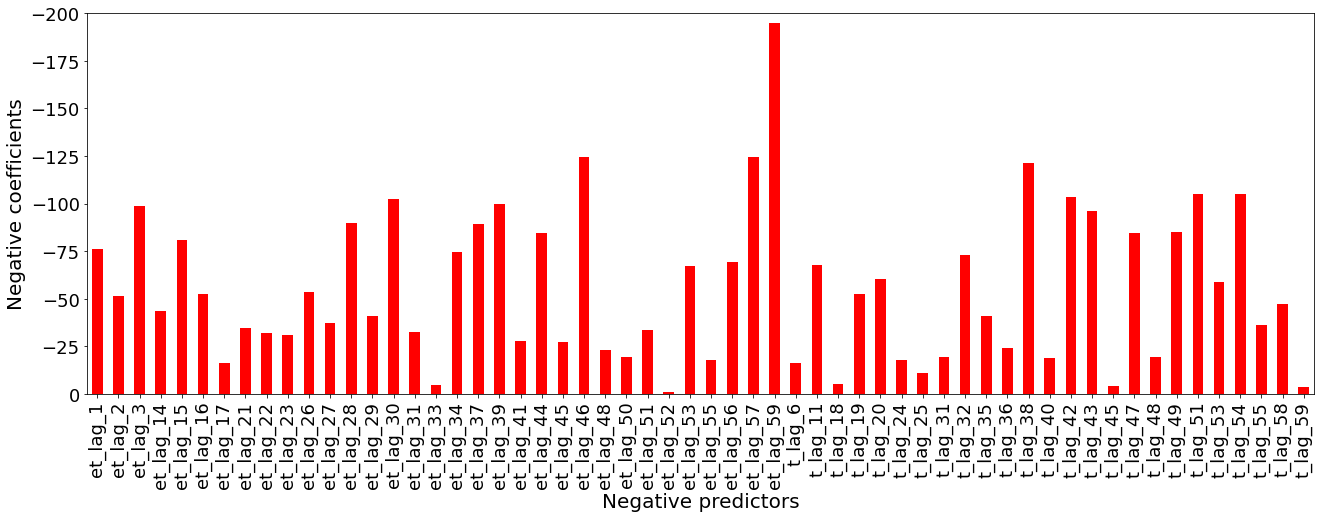

In [39]:
# plot the negative coefficients

df_negative_coe.plot(figsize=(22, 7), xlabel="Negative predictors", fontsize =18, ylim = [0, -200],\
                            color = "r", linewidth=5,ylabel = "Negative coefficients", legend=False , kind ="bar")

# saving the fig
plt.savefig("/content/drive/MyDrive/Thesis-Afshari/figures/coeficient_basel_negative.png",bbox_inches='tight', dpi=150) 

### Evaluation

In [40]:
# evaluate pcr model using nse and kge
streamflow_pcr = q_basel.pcr[len_:]
nse_pcr = he.evaluator(he.nse, streamflow_pcr,y_test)
kge_pcr, r_pcr, alpha_pcr, beta_pcr = he.evaluator(he.kge, streamflow_pcr, y_test)
print("The nse and kge of the PCR model are {:.2} and {:.2} respectively.".format(nse_pcr[0], kge_pcr[0]))

# predicting for model with only meteorological variables
y_pred =  lm.predict(X_test)

# predicting for model with meteorological variables + lagged variables
y_pred_lagged = lm_lag.predict(X_test_lagged)

# evaluate the prediction using nse and kge for model with only meteorological variables
nse = he.evaluator(he.nse, y_pred, y_test)
kge, r, alpha, beta = he.evaluator(he.kge, y_pred, y_test)

# evaluate the prediction using nse and kge for model with meteorological variables + lagged variables
nse_lag = he.evaluator(he.nse, y_pred_lagged, y_test)
kge_lag, r_lag, alpha_lag, beta_lag = he.evaluator(he.kge, y_pred_lagged, y_test)
print("The nse and kge of the linear model are {:.2} and {:.2} respectively.".format(nse[0], kge[0]))
print("The nse and kge of the linear model including lagged variables are {:.2} and {:.2} respectively.".format(nse_lag[0], kge_lag[0]))

The nse and kge of the PCR model are 0.22 and 0.64 respectively.
The nse and kge of the linear model are 0.12 and 0.12 respectively.
The nse and kge of the linear model including lagged variables are 0.68 and 0.72 respectively.


In [ ]:
# saving y_preds
np.save("/content/drive/MyDrive/Thesis-Afshari/output/yhat_MLR_basel.npy", y_pred, allow_pickle=True)
np.save("/content/drive/MyDrive/Thesis-Afshari/output/yaht_MLR_60lag_basel.npy", y_pred_lagged , allow_pickle=True)
